<a href="https://colab.research.google.com/github/brunocosouza/deep_learning/blob/main/keras_using_pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

### Load the training, validation, and test sets 

In [2]:
X_train   = np.load('X_train.npy')
Y_train   = np.load('Y_train.npy')
X_valid   = np.load('X_valid.npy')
Y_valid   = np.load('Y_valid.npy')
X_test    = np.load('X_test.npy')
Y_test   = np.load('Y_test.npy')

xsize     = X_train.shape[1]
ysize     = X_train.shape[2]
nchannels = X_train.shape[3]
nclasses  = np.amax(Y_train) + 1
img_size  = (xsize, ysize)

Y_train = tf.keras.utils.to_categorical(Y_train)
Y_valid = tf.keras.utils.to_categorical(Y_valid)
Y_test  = tf.keras.utils.to_categorical(Y_test)

In [14]:
Y_train.shape, Y_valid.shape, Y_test.shape

((213, 6), (71, 6), (71, 6))

### Load the VGG16 model pretrained on ImageNet

In [7]:
# Loads a pretrained model without the classifier layers (top) to process images with a given shape

backbone = VGG16(weights='imagenet', include_top=False, input_shape=(xsize,ysize,nchannels))
backbone.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
______________________________________________________________

### Extract features from the training, validation, and test sets 

In [8]:
feats_train = backbone.predict(X_train)
feats_valid = backbone.predict(X_valid)
feats_test  = backbone.predict(X_test)

In [15]:
feats_train.shape, feats_valid.shape, feats_test.shape

((213, 6, 6, 512), (71, 6, 6, 512), (71, 6, 6, 512))

### Define and train a MLP classifier

In [16]:
def DenseClassifier():
    classifier = models.Sequential()
    classifier.add(layers.Flatten())
    classifier.add(layers.Dropout(0.5))
    classifier.add(layers.Dense(512, name='dense1', activation='relu'))
    # For categorical datasets (classes are 0,1,2,...,c-1)
    classifier.add(layers.Dense(nclasses, name='decision', activation='softmax'))
    # Choose optimizer and compile the model
    opt  = optimizers.Adam(learning_rate=1e-4)
    #opt = optimizers.RMSprop(learning_rate=1e-4)
    #opt = optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    classifier.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
    return(classifier)
                   
def TrainClassifier(classifier, nepochs, batchsize):
    history  = classifier.fit(feats_train,Y_train,epochs=nepochs,batch_size=batchsize,
                              validation_data=(feats_valid,Y_valid))
    return(history)   

In [17]:
tf.keras.backend.clear_session() 
np.random.seed(42)            
tf.random.set_seed(42)
# Create DenseClassifier
classifier = DenseClassifier()

#Training
history    = TrainClassifier(classifier,10,20)
classifier.summary()

Epoch 1/10
11/11 [==============================] - 2s 89ms/step - loss: 9.2856 - acc: 0.5070 - val_loss: 1.3530 - val_acc: 0.8451
Epoch 2/10
11/11 [==============================] - 1s 70ms/step - loss: 0.2834 - acc: 0.9577 - val_loss: 0.2478 - val_acc: 0.9718
Epoch 3/10
11/11 [==============================] - 1s 68ms/step - loss: 0.0334 - acc: 0.9906 - val_loss: 0.0917 - val_acc: 0.9718
Epoch 4/10
11/11 [==============================] - 1s 71ms/step - loss: 0.0118 - acc: 0.9953 - val_loss: 0.0399 - val_acc: 0.9859
Epoch 5/10
11/11 [==============================] - 1s 71ms/step - loss: 0.0632 - acc: 0.9953 - val_loss: 0.0345 - val_acc: 0.9859
Epoch 6/10
11/11 [==============================] - 1s 71ms/step - loss: 6.7160e-09 - acc: 1.0000 - val_loss: 0.0560 - val_acc: 0.9859
Epoch 7/10
11/11 [==============================] - 1s 71ms/step - loss: 0.0694 - acc: 0.9953 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 8/10
11/11 [==============================] - 1s 72ms/step - loss: 5.7021

### Show training history

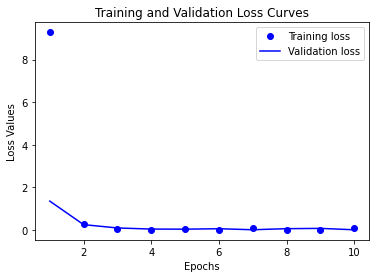

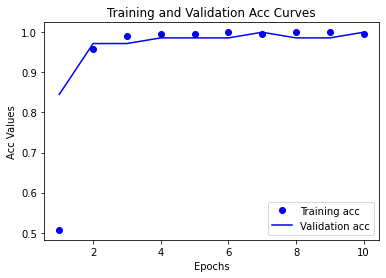

In [18]:
def PlotHistory(history):
    history_dict    = history.history
    train_loss      = history_dict['loss']
    valid_loss      = history_dict['val_loss']
    epochs          = [ i for i in range(1, len(train_loss)+1)]
    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, valid_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    plt.legend()
    plt.show()
    plt.clf() # Clear the figure
    train_acc       = history_dict['acc']
    valid_acc       = history_dict['val_acc']
    plt.plot(epochs, train_acc, 'bo', label='Training acc')
    plt.plot(epochs, valid_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Acc Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Acc Values')
    plt.legend()
    plt.show() 
    
PlotHistory(history)    

### Evaluate your classifer with the backbone from VGG-16

In [19]:
scores = classifier.evaluate(feats_test, Y_test, verbose=1)

3/3 [==============================] - 0s 17ms/step - loss: 0.0852 - acc: 0.9859


### Classify a selected image

In [31]:
def GetClass(preds):
    imax          = 0
    vmax          = preds[0][0]
    for i in range(1,len(preds[0])):
        if preds[0][i] > vmax:
            vmax = preds[0][i]
            imax = i

    return(imax+1)

# Image path to image tensor 
def ImagePathToTensor(img_path, size):
    img    = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array  = tf.keras.preprocessing.image.img_to_array(img) # numpy array
    tensor = np.expand_dims(array, axis=0)               # tensor array
    tensor = tf.keras.applications.xception.preprocess_input(tensor)
    return tensor

img_path      = "0001_0033.png"
img           = ImagePathToTensor(img_path, img_size)

# Print the top class
feats         = backbone.predict(img)
preds         = classifier.predict(feats)
print(preds)
label         = GetClass(preds)
print("Class: ", label)

[[0.05695082 0.01899421 0.01138235 0.01226344 0.8391466  0.06126257]]
Class:  5


### Create and fine-tune a pretrained model on your dataset. 

In [29]:
# You will need access to the backbone layers, which requires to include its architecture here.
def ModelForFineTuning(backbone):
    newmodel = models.Sequential()
    # Add the backbone from VGG-16
    newmodel.add(layers.Conv2D(input_shape=(xsize,ysize,nchannels), name='block1_conv1',filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    newmodel.add(layers.Conv2D(filters=64,name='block1_conv2',kernel_size=(3,3),padding="same", activation="relu"))
    newmodel.add(layers.MaxPool2D(pool_size=(2,2),name='block1_pool',strides=(2,2)))
    newmodel.add(layers.Conv2D(filters=128, name='block2_conv1', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.Conv2D(filters=128, name='block2_conv2', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.MaxPool2D(pool_size=(2,2), name='block2_pool',strides=(2,2)))
    newmodel.add(layers.Conv2D(filters=256, name='block3_conv1', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.Conv2D(filters=256, name='block3_conv2', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.Conv2D(filters=256, name='block3_conv3', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.MaxPool2D(pool_size=(2,2),name='block3_pool',strides=(2,2)))
    newmodel.add(layers.Conv2D(filters=512, name='block4_conv1', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.Conv2D(filters=512, name='block4_conv2', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.Conv2D(filters=512, name='block4_conv3', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.MaxPool2D(pool_size=(2,2),name='block4_pool', strides=(2,2)))
    newmodel.add(layers.Conv2D(filters=512, name='block5_conv1', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.Conv2D(filters=512, name='block5_conv2', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.Conv2D(filters=512, name='block5_conv3', kernel_size=(3,3), padding="same", activation="relu"))
    newmodel.add(layers.MaxPool2D(pool_size=(2,2), name='block5_pool', strides=(2,2)))
    # Set the weights and bias of the backbone pretrained on ImageNet
    newmodel.set_weights(backbone.get_weights()) 
    # Add the MLP classifier
    newmodel.add(layers.Flatten())
    newmodel.add(layers.Dropout(0.5))
    newmodel.add(layers.Dense(512, name='dense1', activation='relu')) 
    newmodel.add(layers.Dense(nclasses, name='decision', activation='softmax')) 
    # Choose optimizer and compile the model
    opt = optimizers.Adam(learning_rate=1e-4)
    #opt = optimizers.RMSprop(learning_rate=1e-4)
    #opt = optimizers.Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    newmodel.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
    # Select the layers you want to train -- fine tune only the last layer of the backbone.
    trainable_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'Dense1', 'decision']
    for layer in newmodel.layers[:-1]: 
        if (layer.name in trainable_layers):
            layer.trainable = True
        else:
            layer.trainable = False
    return(newmodel)
    
    
def TrainCNNModel(model, nepochs, batchsize):
    history    = model.fit(X_train,Y_train,epochs=nepochs,batch_size=batchsize,validation_data=(X_valid,Y_valid))
    return(history)


In [ ]:
ftmodel  = ModelForFineTuning(backbone)            
ftmodel.summary()
history  = TrainCNNModel(ftmodel,10,20) # you will need more epochs to properly train the model
PlotHistory(history)

## Create a class instead of function

In [57]:
# You will need access to the backbone layers, which requires to include its architecture here.
class ModelFineTuning:
  def __init__(self, backbone, learning_rate = 1e-4):
    self.backbone = backbone
    self.lr = learning_rate

  def build_model(self):
      self.newmodel = models.Sequential()
      # Add the backbone from VGG-16
      self.newmodel.add(layers.Conv2D(input_shape=(xsize,ysize,nchannels), name='block1_conv1',filters=64,kernel_size=(3,3),padding="same", activation="relu"))
      self.newmodel.add(layers.Conv2D(filters=64,name='block1_conv2',kernel_size=(3,3),padding="same", activation="relu"))
      self.newmodel.add(layers.MaxPool2D(pool_size=(2,2),name='block1_pool',strides=(2,2)))
      self.newmodel.add(layers.Conv2D(filters=128, name='block2_conv1', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.Conv2D(filters=128, name='block2_conv2', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.MaxPool2D(pool_size=(2,2), name='block2_pool',strides=(2,2)))
      self.newmodel.add(layers.Conv2D(filters=256, name='block3_conv1', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.Conv2D(filters=256, name='block3_conv2', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.Conv2D(filters=256, name='block3_conv3', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.MaxPool2D(pool_size=(2,2),name='block3_pool',strides=(2,2)))
      self.newmodel.add(layers.Conv2D(filters=512, name='block4_conv1', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.Conv2D(filters=512, name='block4_conv2', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.Conv2D(filters=512, name='block4_conv3', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.MaxPool2D(pool_size=(2,2),name='block4_pool', strides=(2,2)))
      self.newmodel.add(layers.Conv2D(filters=512, name='block5_conv1', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.Conv2D(filters=512, name='block5_conv2', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.Conv2D(filters=512, name='block5_conv3', kernel_size=(3,3), padding="same", activation="relu"))
      self.newmodel.add(layers.MaxPool2D(pool_size=(2,2), name='block5_pool', strides=(2,2)))
      # Set the weights and bias of the backbone pretrained on ImageNet
      self.newmodel.set_weights(self.backbone.get_weights()) 
      # Add the MLP classifier
      self.newmodel.add(layers.Flatten())
      self.newmodel.add(layers.Dropout(0.5))
      self.newmodel.add(layers.Dense(512, name='dense1', activation='relu')) 
      self.newmodel.add(layers.Dense(nclasses, name='decision', activation='softmax')) 
      # Choose optimizer and compile the model
      opt = optimizers.Adam(self.lr)
      #opt = optimizers.RMSprop(learning_rate=1e-4)
      #opt = optimizers.Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
      self.newmodel.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
      # Select the layers you want to train -- fine tune only the last layer of the backbone.
      trainable_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'Dense1', 'decision']
      for layer in self.newmodel.layers[:-1]: 
          if (layer.name in trainable_layers):
              layer.trainable = True
          else:
              layer.trainable = False
      return self.newmodel
      
  def train(self, X_train,Y_train, X_valid,Y_valid, nepochs, batchsize):
    history = self.newmodel.fit(X_train,Y_train,epochs=nepochs,batch_size=batchsize,validation_data=(X_valid,Y_valid))
    return history

In [ ]:
ftmodel  = ModelFineTuning(backbone, learning_rate = 0.01)
ftmodel.build_model()
hist = ftmodel.train(X_train, Y_train, X_valid, Y_valid, 10, 20)

Epoch 1/10
11/11 [==============================] - 350s 32s/step - loss: 4.8701 - acc: 0.3005 - val_loss: 1.5699 - val_acc: 0.3662
Epoch 2/10
11/11 [==============================] - 349s 32s/step - loss: 1.4072 - acc: 0.4366 - val_loss: 0.9088 - val_acc: 0.5775
Epoch 3/10
11/11 [==============================] - 345s 32s/step - loss: 0.8674 - acc: 0.6761 - val_loss: 0.4795 - val_acc: 0.8028
Epoch 4/10
11/11 [==============================] - 349s 32s/step - loss: 0.4434 - acc: 0.8263 - val_loss: 0.2932 - val_acc: 0.9014
Epoch 5/10
11/11 [==============================] - 353s 32s/step - loss: 0.3527 - acc: 0.8498 - val_loss: 0.2928 - val_acc: 0.9155
Epoch 6/10
11/11 [==============================] - 348s 32s/step - loss: 0.2740 - acc: 0.9014 - val_loss: 0.4126 - val_acc: 0.8310
Epoch 7/10
11/11 [==============================] - 352s 32s/step - loss: 0.1838 - acc: 0.9343 - val_loss: 0.2739 - val_acc: 0.9296
Epoch 8/10
 6/11 [===============>..............] - ETA: 2:30 - loss: 0.1321

### Save and evaluate model

In [32]:
ftmodel.save("ftmodel.h5")
scores = ftmodel.evaluate(X_test, Y_test, verbose=1)

3/3 [==============================] - 31s 8s/step - loss: 0.7904 - acc: 0.7324


### Curiosity: How to extract and save weights and bias from all convolutional layers

In [33]:
nlayers              = len(ftmodel.layers) 
backbone_conv_layers = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 
                        'block3_conv1', 'block3_conv2', 'block3_conv3', 
                        'block4_conv1', 'block4_conv2', 'block4_conv3', 
                        'block5_conv1', 'block5_conv2', 'block5_conv3']
for i in range(nlayers): # another way to access layers
    if (ftmodel.layers[i].name in backbone_conv_layers):
        weights = ftmodel.layers[i].get_weights()[0]
        bias    = ftmodel.layers[i].get_weights()[1]
        np.save("{}_weights.npy".format(ftmodel.layers[i].name),weights)
        np.save("{}_bias.npy".format(ftmodel.layers[i].name),bias)

### Curiosity: How to load and set weights and bias to convolutional layers

In [ ]:
nlayers = len(backbone_conv_layers)
weights = np.load("block1_conv1_weights.npy")
bias    = np.load("block1_conv1_bias.npy")
for i in range(nlayers):
    if (backbone.layers[i].name == 'block1_conv1'):
        backbone.layers[i].set_weights([weights, bias])

# Load the ResNet50 model pretrained on ImageNet

In [34]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [35]:
# Loads a pretrained model without the classifier layers (top) to process images with a given shape

backbone_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(xsize,ysize,nchannels))
backbone_resnet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
__________________________

In [37]:
def DenseClassifier():
    classifier = models.Sequential()
    classifier.add(layers.Flatten())
    classifier.add(layers.Dropout(0.5))
    classifier.add(layers.Dense(512, name='dense1', activation='relu'))
    # For categorical datasets (classes are 0,1,2,...,c-1)
    classifier.add(layers.Dense(nclasses, name='decision', activation='softmax'))
    # Choose optimizer and compile the model
    opt  = optimizers.Adam(learning_rate=1e-4)
    #opt = optimizers.RMSprop(learning_rate=1e-4)
    #opt = optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    classifier.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
    return(classifier)
                   
def TrainClassifier(feats_train, Y_train, classifier, feats_valid, Y_valid,  nepochs, batchsize):
    history  = classifier.fit(feats_train,Y_train,epochs=nepochs,batch_size=batchsize,
                              validation_data=(feats_valid,Y_valid))
    return(history)   

In [36]:
feats_train_resnet = backbone.predict(X_train)
feats_valid_resnet = backbone.predict(X_valid)
feats_test_resnet = backbone.predict(X_test)

In [38]:
tf.keras.backend.clear_session() 
np.random.seed(42)            
tf.random.set_seed(42)
# Create DenseClassifier
classifier = DenseClassifier()

#Training
history    = TrainClassifier(feats_train_resnet, Y_train, classifier, feats_valid_resnet, Y_valid, 10,20)
classifier.summary()

Epoch 1/10
11/11 [==============================] - 1s 68ms/step - loss: 9.2856 - acc: 0.5070 - val_loss: 1.3530 - val_acc: 0.8451
Epoch 2/10
11/11 [==============================] - 1s 56ms/step - loss: 0.2834 - acc: 0.9577 - val_loss: 0.2478 - val_acc: 0.9718
Epoch 3/10
11/11 [==============================] - 1s 56ms/step - loss: 0.0334 - acc: 0.9906 - val_loss: 0.0917 - val_acc: 0.9718
Epoch 4/10
11/11 [==============================] - 1s 56ms/step - loss: 0.0118 - acc: 0.9953 - val_loss: 0.0399 - val_acc: 0.9859
Epoch 5/10
11/11 [==============================] - 1s 56ms/step - loss: 0.0632 - acc: 0.9953 - val_loss: 0.0345 - val_acc: 0.9859
Epoch 6/10
11/11 [==============================] - 1s 56ms/step - loss: 6.7160e-09 - acc: 1.0000 - val_loss: 0.0560 - val_acc: 0.9859
Epoch 7/10
11/11 [==============================] - 1s 56ms/step - loss: 0.0694 - acc: 0.9953 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 8/10
11/11 [==============================] - 1s 55ms/step - loss: 5.7021

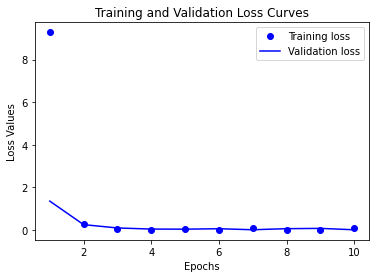

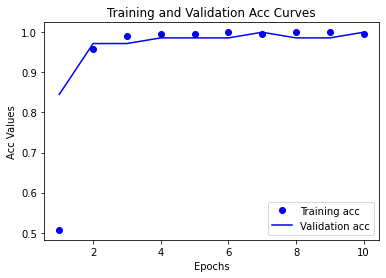

In [39]:
PlotHistory(history)  

In [40]:
ftmodel.save("resnetmodel.h5")
scores = ftmodel.evaluate(X_test, Y_test, verbose=1)

3/3 [==============================] - 28s 8s/step - loss: 0.7904 - acc: 0.7324
